In [46]:
# data manipulation 
import numpy as np
import pandas as pd

from datetime import datetime
import itertools as it

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
import statsmodels.api as sm
from statsmodels.tsa.ar_model import AR

from sklearn.model_selection import TimeSeriesSplit
from sklearn import metrics

import math

# data visualization 
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
%matplotlib inline

# ignore warnings
# import warnings
# warnings.filterwarnings("ignore")

import acquire as acq
import prepare as prep


In [25]:
def plot_data_and_predictions(predictions, label):
    plt.figure(figsize=(10, 8))

    plt.plot(train,label='Train')
    plt.plot(test, label='Test')
    plt.plot(predictions, label=label, linewidth=5)

    plt.legend(loc='best')
    plt.show()


def evaluate(actual, predictions, output=True):
    mse = metrics.mean_squared_error(actual, predictions)
    rmse = math.sqrt(mse)

    if output:
        print('MSE:  {}'.format(mse))
        print('RMSE: {}'.format(rmse))
    else:
        return mse, rmse    

def plot_and_eval(predictions, actual=test, metric_fmt='{:.2f}', linewidth=4):
    if type(predictions) is not list:
        predictions = [predictions]

    plt.figure(figsize=(16, 8))
    plt.plot(train,label='Train')
    plt.plot(test, label='Test')

    for yhat in predictions:
        mse, rmse = evaluate(actual, yhat, output=False)        
        label = f'{yhat.name}'
        if len(predictions) > 1:
            label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.plot(yhat, label=label, linewidth=linewidth)

    if len(predictions) == 1:
        label = f'{label} -- MSE: {metric_fmt} RMSE: {metric_fmt}'.format(mse, rmse)
        plt.title(label)

    plt.legend(loc='best')
    plt.show()    

In [3]:
df, dfc = prep.prep_data(acq.get_data())

In [4]:
df.head(10)

,item_id,sale_amount,sale_id,store_id,item_brand,item_name,item_price,item_upc12,item_upc14,store_address,...,store_state,store_zipcode,year,quarter,month,day,dayofweek,weekday,sales_total,sales_diff
sale_date,,,,,,,,,,,,,,,,,,,,,
2013-05-25,16,16.0,285001,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,25,5,1.0,82.72,NaN
2013-05-26,16,20.0,285002,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,26,6,1.0,103.40,20.68
2013-05-27,16,7.0,285003,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,27,0,0.0,36.19,-67.21
2013-05-28,16,17.0,285004,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,28,1,0.0,87.89,51.70
2013-05-29,16,17.0,285005,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,29,2,0.0,87.89,0.00
2013-05-30,16,20.0,285006,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,30,3,0.0,103.40,15.51
2013-05-31,16,16.0,285007,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,5,31,4,0.0,82.72,-20.68
2013-06-01,16,19.0,285008,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,6,1,5,1.0,98.23,15.51
2013-06-02,16,28.0,285009,7,Burts Bees,Burts Bees Daily Moisturizing Cream Sensitive,5.17,792850014008,792850014008,12018 Perrin Beitel Rd,...,TX,78217,2013,2,6,2,6,1.0,144.76,46.53


In [7]:
dfc.head()

,sales_total_sum,sales_total_mean,sales_amount_sum,sales_amount_mean
weekday,,,,
0.0,1.717040e+08,263.349746,31939325.0,48.986695
1.0,8.475663e+07,324.738049,15765187.0,60.403015


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 913000 entries, 2013-05-25 to 2017-12-31
Data columns (total 21 columns):
item_id          913000 non-null int64
sale_amount      913000 non-null float64
sale_id          913000 non-null int64
store_id         913000 non-null int64
item_brand       913000 non-null object
item_name        913000 non-null object
item_price       913000 non-null float64
item_upc12       913000 non-null int64
item_upc14       913000 non-null int64
store_address    913000 non-null object
store_city       913000 non-null object
store_state      913000 non-null object
store_zipcode    913000 non-null int64
year             913000 non-null int64
quarter          913000 non-null int64
month            913000 non-null int64
day              913000 non-null int64
dayofweek        913000 non-null int64
weekday          913000 non-null float64
sales_total      913000 non-null float64
sales_diff       912999 non-null float64
dtypes: float64(5), int64(11), object(5

In [18]:
aggregation = 'sum' # we might switch this for mean later... or not!

In [19]:
train = df[:'2016'].sale_amount.resample('W').agg(aggregation)
test = df['2017':].sale_amount.resample('W').agg(aggregation)

In [20]:
print('Observations: %d' % (len(train.values) + len(test.values)))
print('Training Observations: %d' % (len(train)))
print('Testing Observations: %d' % (len(test)))

Observations: 262
Training Observations: 209
Testing Observations: 53


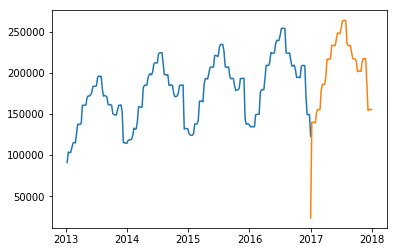

In [21]:
plt.plot(train)
plt.plot(test)
plt.show()

In [22]:
yhat = pd.DataFrame(dict(actual=test))

In [23]:
yhat['avg_forecast'] = train.mean()

In [24]:
yhat.head()

,actual,avg_forecast
sale_date,,
2017-01-01,23709.0,176893.645933
2017-01-08,140112.0,176893.645933
2017-01-15,139901.0,176893.645933
2017-01-22,139914.0,176893.645933
2017-01-29,139345.0,176893.645933


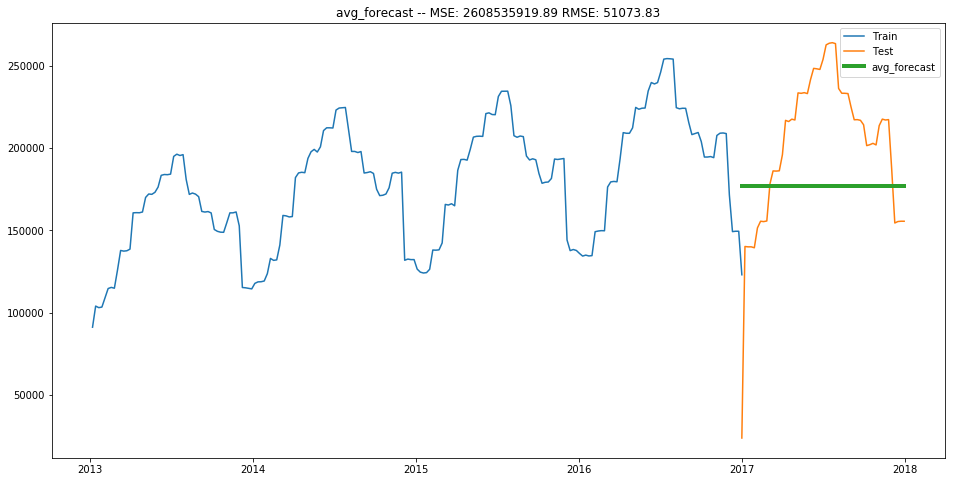

In [26]:
plot_and_eval(yhat.avg_forecast)

In [29]:
periods = 30
yhat['moving_avg_forecast_30'] = train.rolling(30).mean().iloc[-1]

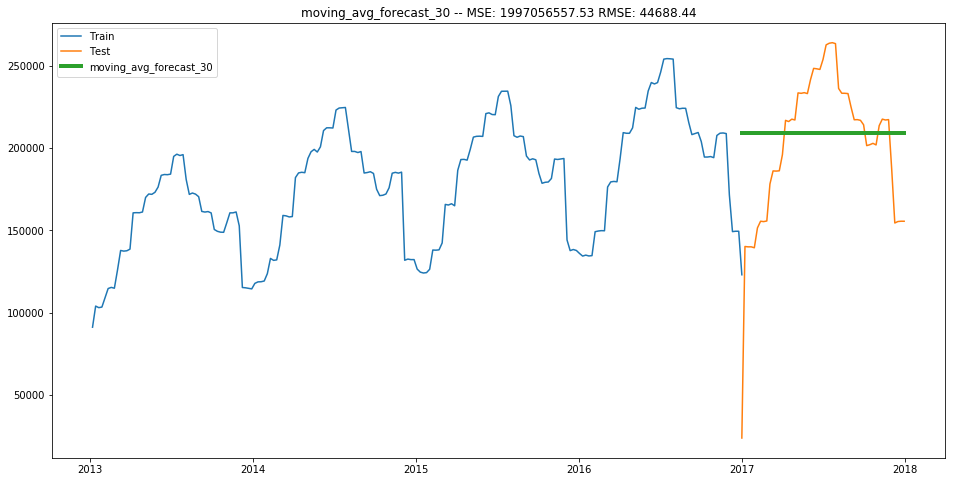

In [30]:
plot_and_eval(yhat.moving_avg_forecast_30)

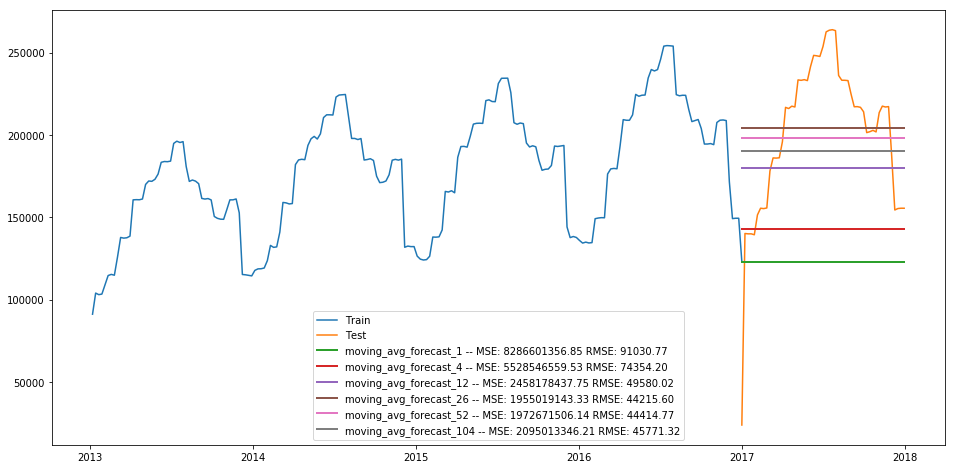

In [31]:
period_vals = [1, 4, 12, 26, 52, 104]

for periods in period_vals:
    yhat[f'moving_avg_forecast_{periods}'] = train.rolling(periods).mean().iloc[-1]

forecasts = [yhat[f'moving_avg_forecast_{p}'] for p in period_vals]

plot_and_eval(forecasts, linewidth=2)

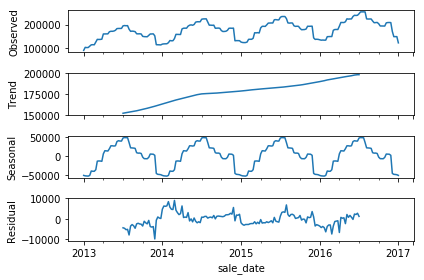

In [32]:
sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

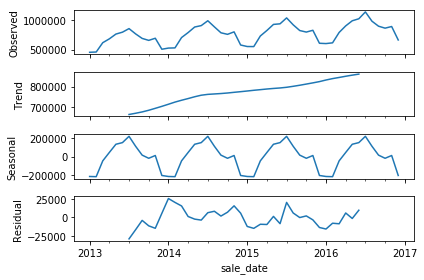

In [36]:
train = df[:'2016'].sale_amount.resample('M').agg(aggregation)
test = df['2017':].sale_amount.resample('M').agg(aggregation)

sm.tsa.seasonal_decompose(train).plot()
result = sm.tsa.stattools.adfuller(train)
plt.show()

In [48]:
Holt(train).fit(smoothing_level=.9, smoothing_slope=.1)

yhat['holt_linear'] = Holt.forecast(test.shape[0])
test

AttributeError: type object 'Holt' has no attribute 'forecast'